In [19]:
import time
import socket
import random
import threading
import matplotlib.pyplot as plt

In [20]:
class AODV(threading.Thread):
    INF = 999
    transfer_loss = {"send":0.005,"receive":0.002}
    transfer_threshold = {"send": 1.5, "receive": 0.5}
    metric = {'dist':-1,'hop': -0.50,'power':0.50}
    BEST_PATH_WAIT_TIME = 1
    ATTEMPT_TIME = 1
    MAX_ATTEMPT = 10

    def __init__(self,addr,coor):
        super(AODV,self).__init__()
        self.addr = addr
        self.coor = coor #[x,y]
        self.node_id = "%s:%s"%addr
        self.rreq_id = 0
        self.power = 5
        self.sent_bytes = 0
        self.received_bytes = 0
        self.parents = {}
        self.childs = {}
        self.routing_table = {}
        self.rreq_id_list = {}
        self.msg_box = {}
        self.pending_msg_q = {}
        self.sock = socket.socket()
        self.sock.bind(addr)
        self.sock.listen(5)
        
    def connect(self,nodes):
        if not isinstance(nodes,list):
            nodes = [nodes]
        for node in nodes:
            s = socket.socket()
            s.connect(node)
            s.send(self.node_id.encode())
            self.parents['%s:%s'%node] = s
            threading.Thread(target=self.listener,args=(s,)).start()
            
    def max_byte(self,operation):
        avail_pow = self.power-self.transfer_threshold[operation]
        byte = avail_pow/self.transfer_loss[operation]
        return int(byte)
    
    def power_loss(self,message,op):
        loss = len(message)*self.transfer_loss[op]
        return loss

    def readline(self,sock):
        try:
            data = sock.recv(1)
            while b'\r\n' not in data:
                data += sock.recv(1)
            return data.decode()
        except:
            return ''

    def listener(self,sock):
        while True:
            message = self.readline(sock)
            if message:
                if message[:4] == 'USER':
                    if len(message)<=self.max_byte('receive'):
                        print('Received %s bytes'%len(message))
                        # Update params
                        self.received_bytes += len(message)
                        self.power -= self.power_loss(message,'receive')
                        self.on_recv(message)
                    else:
                        print('Low power')
                else:
                    self.on_recv(message)

    def on_recv(self,message):
        message = message.split('|')
        # Process message
        switch = {'RREQ':self.process_rreq,
                  'RREP':self.process_rrep,
                  'USER': self.process_user_message}
        switch[message[0]](message)

    def send(self,sock,message):
        if message[:4] != 'USER':
            # send message
            sock.send(message.encode())
        else:
            if len(message)<=self.max_byte('send'):
                # send message
                sock.send(message.encode())
                # Update params
                self.sent_bytes += len(message)
                self.power -= self.power_loss(message,'send')
                print('Sent %s bytes'%len(message))
            else:
                print('Low power')

    def distance(self,coor):
        dx = float(coor[0])-self.coor[0]
        dy = float(coor[1])-self.coor[1]
        return (dx**2+dy**2)**0.5

    def obj_func(self,dictionary):
        score = 0
        for key in dictionary:
            if key in self.metric:
                score += dictionary[key]*self.metric[key]
            else:
                score += dictionary[key]
        return score

    def send_rreq(self,dest):
        self.rreq_id += 1
        rreq_id = self.rreq_id
        orig = self.node_id
        sender = self.node_id
        power = self.INF
        coor = self.coor
        dist = 0
        hop = 0        
        message = 'RREQ|%s|%s|%s|%s|%s,%s|%s|%s|%s|\r\n'%(rreq_id,orig,sender,dest,*self.coor,hop,dist,power)
        for child in self.childs:
            self.send(self.childs[child],message)

    def process_rreq(self,message):
        '''Process an incoming RREQ message'''
        # Extract the relevant parameters from the message
        rreq_id = int(message[1])
        orig = message[2]
        sender = message[3]
        dest = message[4]
        coor = message[5].split(',')
        hop = int(message[6]) + 1
        dist = float(message[7])+self.distance(coor)
        power = min(float(message[8]),self.power)
        # Check if we are the origin. If we are, discard this RREP.
        if (self.node_id == orig):
            return
        # Discard duplicate rreq
        if orig in self.rreq_id_list:
            if self.rreq_id_list[orig] == rreq_id:
                return

        score = self.obj_func({'dist':dist,'power':power,'hop':hop})
        if orig not in self.routing_table:
            self.routing_table[orig] = {
                'Next-Hop':sender,
                'Hop':hop,
                'Distance': dist,
                'Power': power,
                'Score': score
            }
        elif self.routing_table[orig]['Score']<score:
            # Update routing table
            self.routing_table[orig] = {
                'Next-Hop':sender,
                'Hop':hop,
                'Distance': dist,
                'Power': power,
                'Score': score
            }
            return
        else:
            return
        if orig not in self.rreq_id_list:
            if self.node_id == dest:                
                timer = threading.Timer(self.BEST_PATH_WAIT_TIME,self.send_rrep,[orig,])
            else:
                timer = threading.Timer(self.BEST_PATH_WAIT_TIME,self.forward_rreq,[message,])
            timer.start()

    def forward_rreq(self,message):
        '''Rebroadcast an RREQ request (Called when RREQ is received by an intermediate node)'''
        rreq_id = message[1]
        orig = message[2]
        # Buffer rreq_id to discard rreq after sending rrep for forwarding rreq
        self.rreq_id_list[orig] = rreq_id
        # Check the routing table is deleted or not
        if orig in self.routing_table:
            route = self.routing_table[orig]
            message[3] = self.node_id
            message[7] = str(route['Distance'])
            message[5] = '%s,%s'%tuple(self.coor)
            message[6] = str(route['Hop'])
            message[8] = str(route['Power'])
            message = '|'.join(message)
            for conn in self.childs.values():
                self.send(conn,message)

    def send_rrep(self,dest):
        '''Send an RREP message back to the RREQ originator'''
        orig = self.node_id
        sender = self.node_id
        power = self.INF
        coor = self.coor
        dist = 0
        hop = 0
        message = 'RREP|%s|%s|%s|%s,%s|%s|%s|%s|\r\n'%(orig,sender,dest,*coor,hop,dist,power)
        next_hop = self.routing_table[dest]['Next-Hop']
        self.send(self.parents[next_hop],message)

    def process_rrep(self,message):
        '''Process an incoming RREP message'''
        # Extract the relevant fields from the message
        orig = message[1]
        sender = message[2]
        dest = message[3]
        coor = message[4].split(',')
        hop = int(message[5]) + 1
        dist = float(message[6])+self.distance(coor)
        power = min(float(message[7]),self.power)
        score = self.obj_func({'dist':dist,'power':power,'hop':hop})
        self.routing_table[orig] = {
            'Next-Hop':sender,
            'Hop':hop,
            'Distance': dist,
            'Power': power,
            'Score': score
        }
        if self.node_id != dest:
            self.forward_rrep(message)

    def forward_rrep(self,message):
        orig = message[1]
        dest = message[3]
        route = self.routing_table[orig]
        message[2] = self.node_id
        message[6] = str(route['Distance'])
        message[4] = '%s,%s'%tuple(self.coor)
        message[5] = str(route['Hop'])
        message[7] = str(route['Power'])
        message = '|'.join(message)
        next_hop = self.routing_table[dest]['Next-Hop']
        self.send(self.parents[next_hop],message)

    def send_user_message(self,dest,msg_data):
        message = 'USER|%s|%s|%s|\r\n'%(self.node_id,dest,msg_data)
        self.send_rreq(dest)
        for _ in range(self.MAX_ATTEMPT):
            if dest in self.routing_table:
                next_hop = self.routing_table[dest]['Next-Hop']
                self.send(self.childs[next_hop],message)
                # send pending msg if available
                if self.pending_msg_q:
                    self.send_pending_msgs()
                return
            else:
                time.sleep(self.ATTEMPT_TIME)
        self.pending_msg_q[dest] = {'orig':self.node_id,'msg_data':msg_data}

    def process_user_message(self,message):
        orig = message[1]
        dest = message[2]
        msg_data = message[3]
        if self.node_id == dest:
            self.msg_box[orig] = msg_data
            print('New message arrived')
        else:
            self.forward_user_message(message)

    def forward_user_message(self,message):
        orig = message[1]
        dest = message[2]
        msg_data = message[3]
        message = '|'.join(message)
        if dest in self.routing_table:
            next_hop = self.routing_table[dest]['Next-Hop']
            self.send(self.childs[next_hop],message)

    def run(self):
        while True:
            try:
                conn , _ = self.sock.accept()
                self.childs[conn.recv(21).decode()] = conn
                threading.Thread(target=self.listener,args=(conn,)).start()
            except:
                print('Connection closed\n')
                break

In [21]:
class Node(AODV):
    def __init__(self,addr,dist_range=[1,50]):
        coor = [random.randint(*dist_range), random.randint(*dist_range)]
        super(Node,self).__init__(addr,coor)

In [28]:
class Network:
    MAX_ATTEMPT = 10
    ATTEMPT_TIME = 0.5

    def __init__(self,no_of_node,ip='127.0.0.1',start_port=8000):
        self.no_of_node = no_of_node
        self.nodes = {}
        for i in range(no_of_node):
            addr = (ip,start_port+i)
            self.nodes['%s:%s'%addr] = Node(addr)
            self.nodes['%s:%s'%addr].start()
        # Initilize neighbour
        self.init_neighbour()

    def init_neighbour(self):
        for node in self.nodes:
            self.nodes[node].routing_table = {}
            self.nodes[node].parents = {}
            self.nodes[node].childs = {}
        for node1 in self.nodes:
            for node2 in self.nodes:
                if self.nodes[node1].distance(self.nodes[node2].coor) <= self.nodes[node1].power**2 and node1 != node2:
                    self.nodes[node2].connect(self.nodes[node1].addr)

    def shutdown(self):
        for node in self.nodes.values():
            node.sock.close()
            for parent in node.parents.values():
                parent.close()

    def reset(self,factor):
        for node in self.nodes:
            self.nodes[node].metric = {'dist':-1,'hop': -1*factor,'power':factor}
            self.nodes[node].rreq_id = 0
            self.nodes[node].power = 5
            self.nodes[node].sent_bytes = 0
            self.nodes[node].received_bytes = 0
            self.nodes[node].routing_table = {}
            self.nodes[node].rreq_id_list = {}
            self.nodes[node].msg_box = {}
            self.nodes[node].pending_msg_q = {}

    def plot_transfer_stat(self,dest):
        transfer = []
        power = []
        for i in [0.0,0.2,0.4,0.6,0.8,1.0]:
            total = 0
            self.reset(i)               
            self.start_season(dest)
            for name,node in self.nodes.items():
                total += node.received_bytes+node.sent_bytes
            transfer.append(total/self.no_of_node)
            power.append(i)
        plt.plot(power,transfer)
        plt.show()

    def plt_dest_connection(self,dest):
        for node in self.nodes.values():
            if node.node_id != dest:
                node.send_rreq(dest)
                for _ in range(self.MAX_ATTEMPT):
                    if dest in node.routing_table:
                        route = node.routing_table[dest]
                        x = [self.nodes[route['Next-Hop']].coor[0],node.coor[0]]
                        y = [self.nodes[route['Next-Hop']].coor[1],node.coor[1]]
                        plt.plot(x, y, '-o')
                        break
                    time.sleep(self.ATTEMPT_TIME)

    def plot_neighbour_connection(self):
        for node in self.nodes:
            for child in self.nodes[node].childs:
                x = [self.nodes[node].coor[0],self.nodes[child].coor[0]]
                y = [self.nodes[node].coor[1],self.nodes[child].coor[1]]
                plt.plot(x, y, '-o')
 
    def plot_network(self):
        x=[]
        y=[]
        c=[]
        s=[]
        plt.figure(figsize=(30,15),dpi=200)
        for node in self.nodes.values():
            x.append(node.coor[0])
            y.append(node.coor[1])
            c.append(node.power)
            s.append(3.14*25**2) # mult 8.1
            plt.text(x[-1], y[-1],node.node_id,size=20,horizontalalignment='center',verticalalignment='center',bbox=dict(facecolor='red', alpha=0.4))
        plt.scatter(x, y, s=s, c=c, alpha=0.6,picker=True)
        plt.grid(True)

    def start_season(self,dest):
        for node in self.nodes:
            if node != dest:
                self.init_neighbour()
                self.nodes[node].send_user_message(dest,'PING')
                time.sleep(1)
                # Check whether msg reaches to dest
                for _ in range(self.MAX_ATTEMPT):
                    if node in self.nodes[dest].msg_box:
                        break
                    time.sleep(self.ATTEMPT_TIME)

In [29]:
try:network.shutdown()
except:pass
network = Network(10)

Connection closed
Connection closed


Connection closed

Connection closed

Connection closed

Connection closed

Connection closed

Connection closed

Connection closed

Connection closed



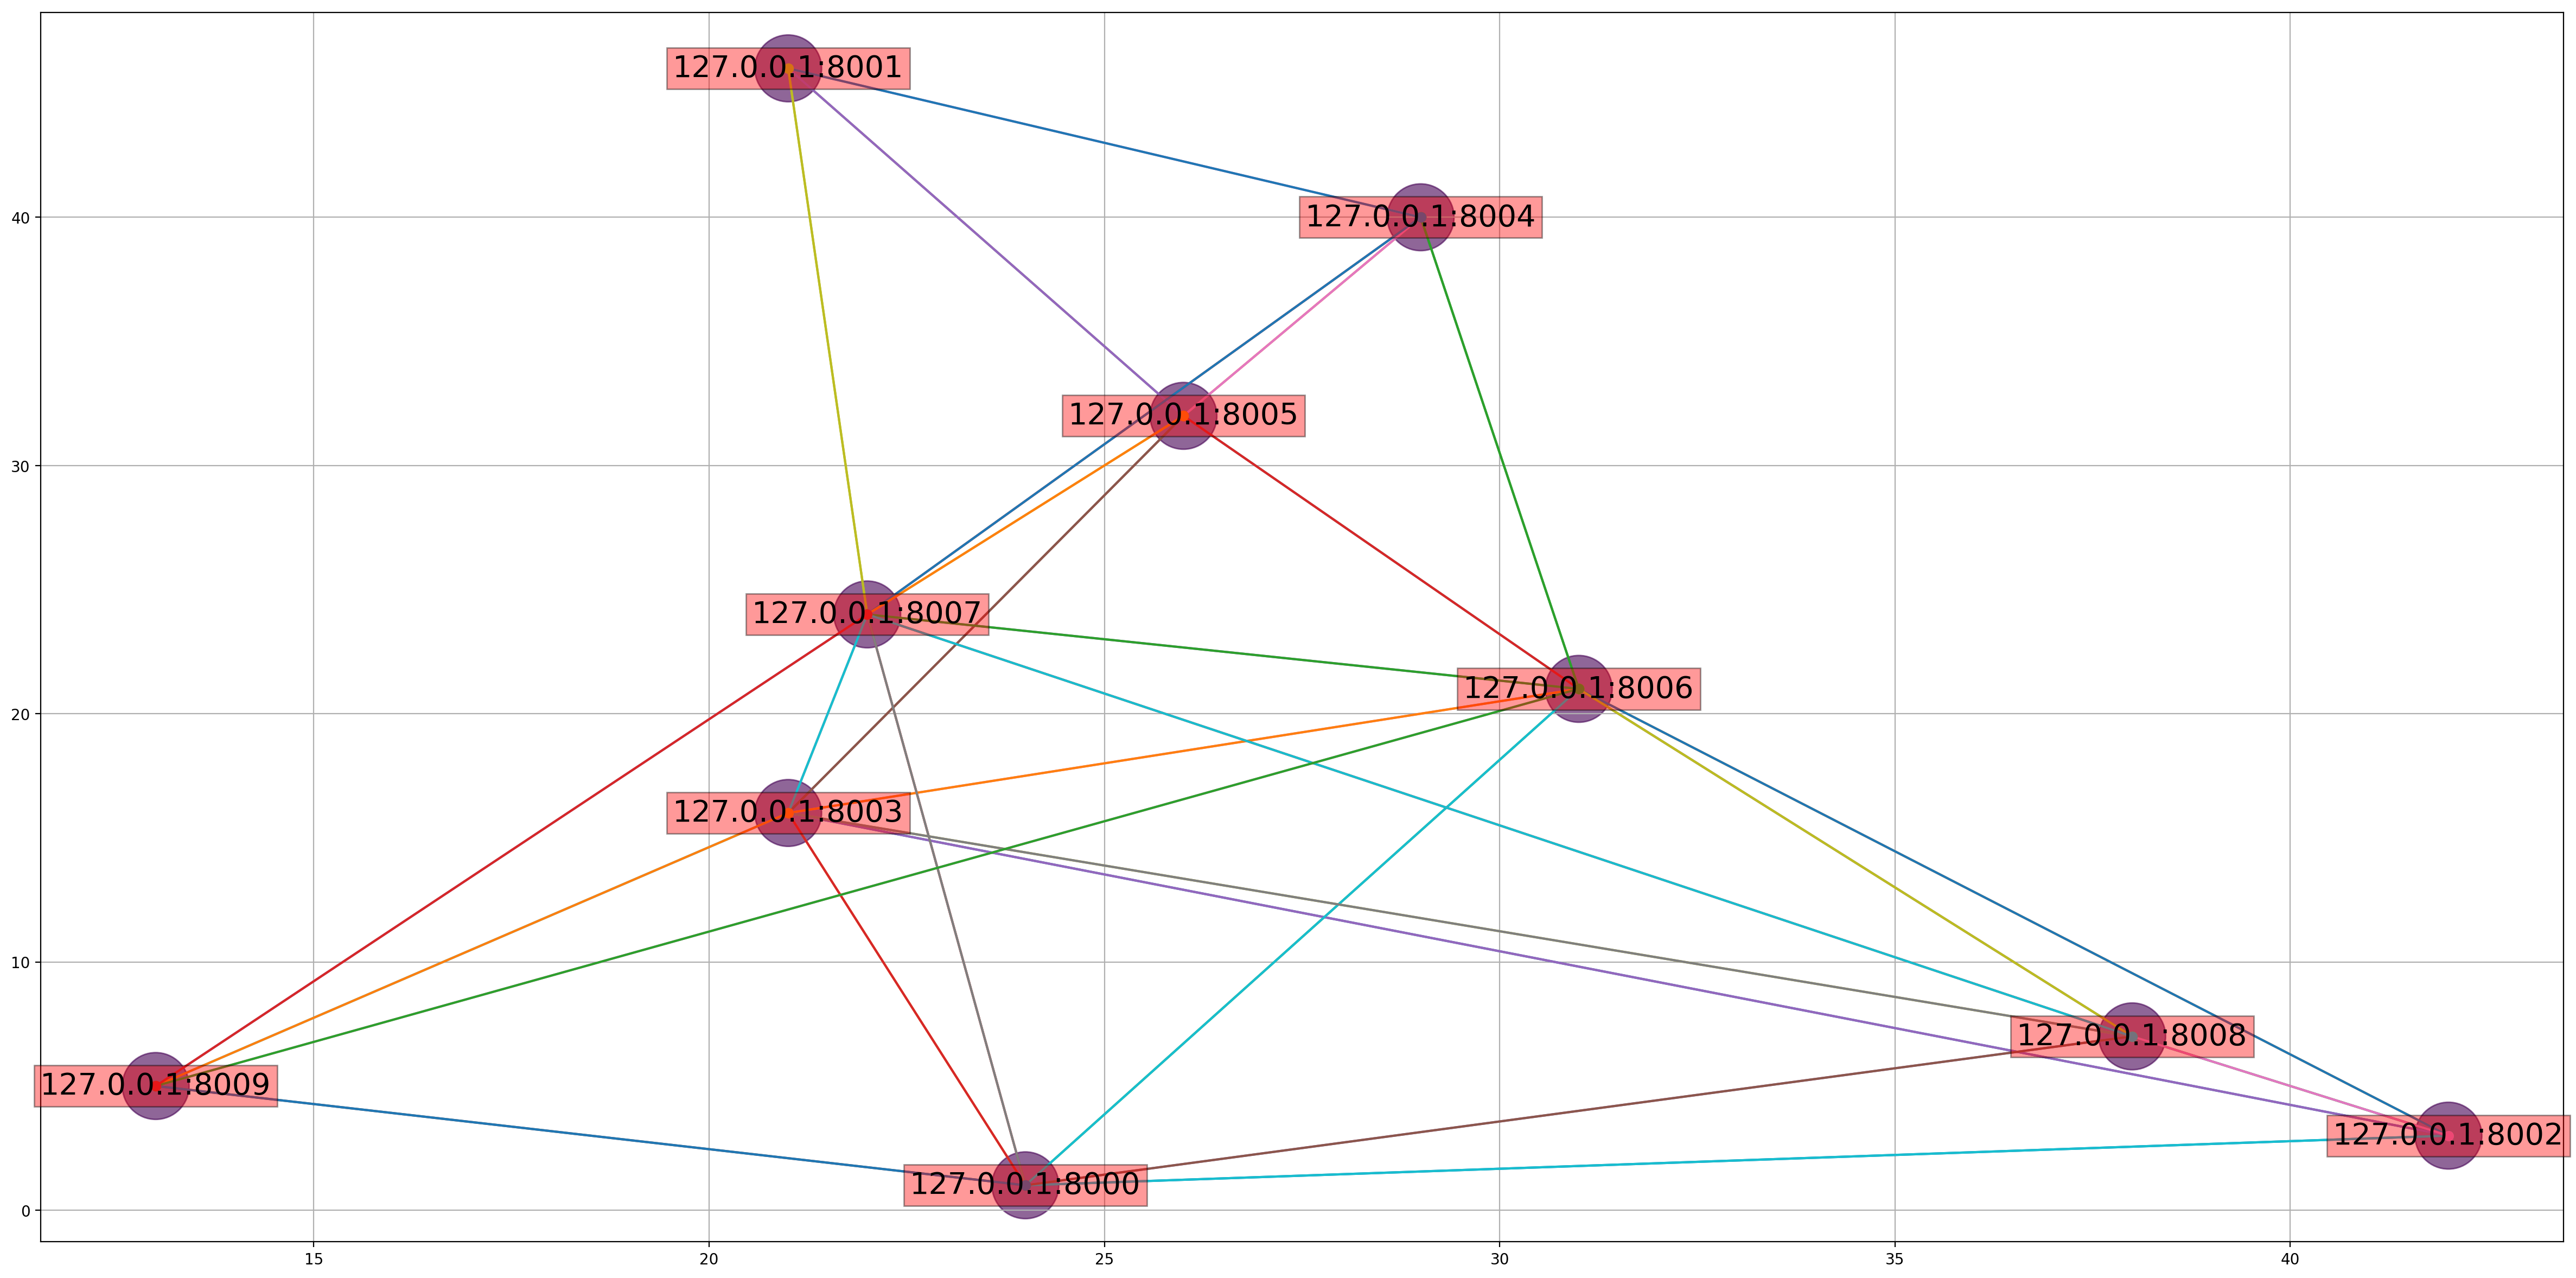

In [30]:
network.plot_network()
network.plot_neighbour_connection()

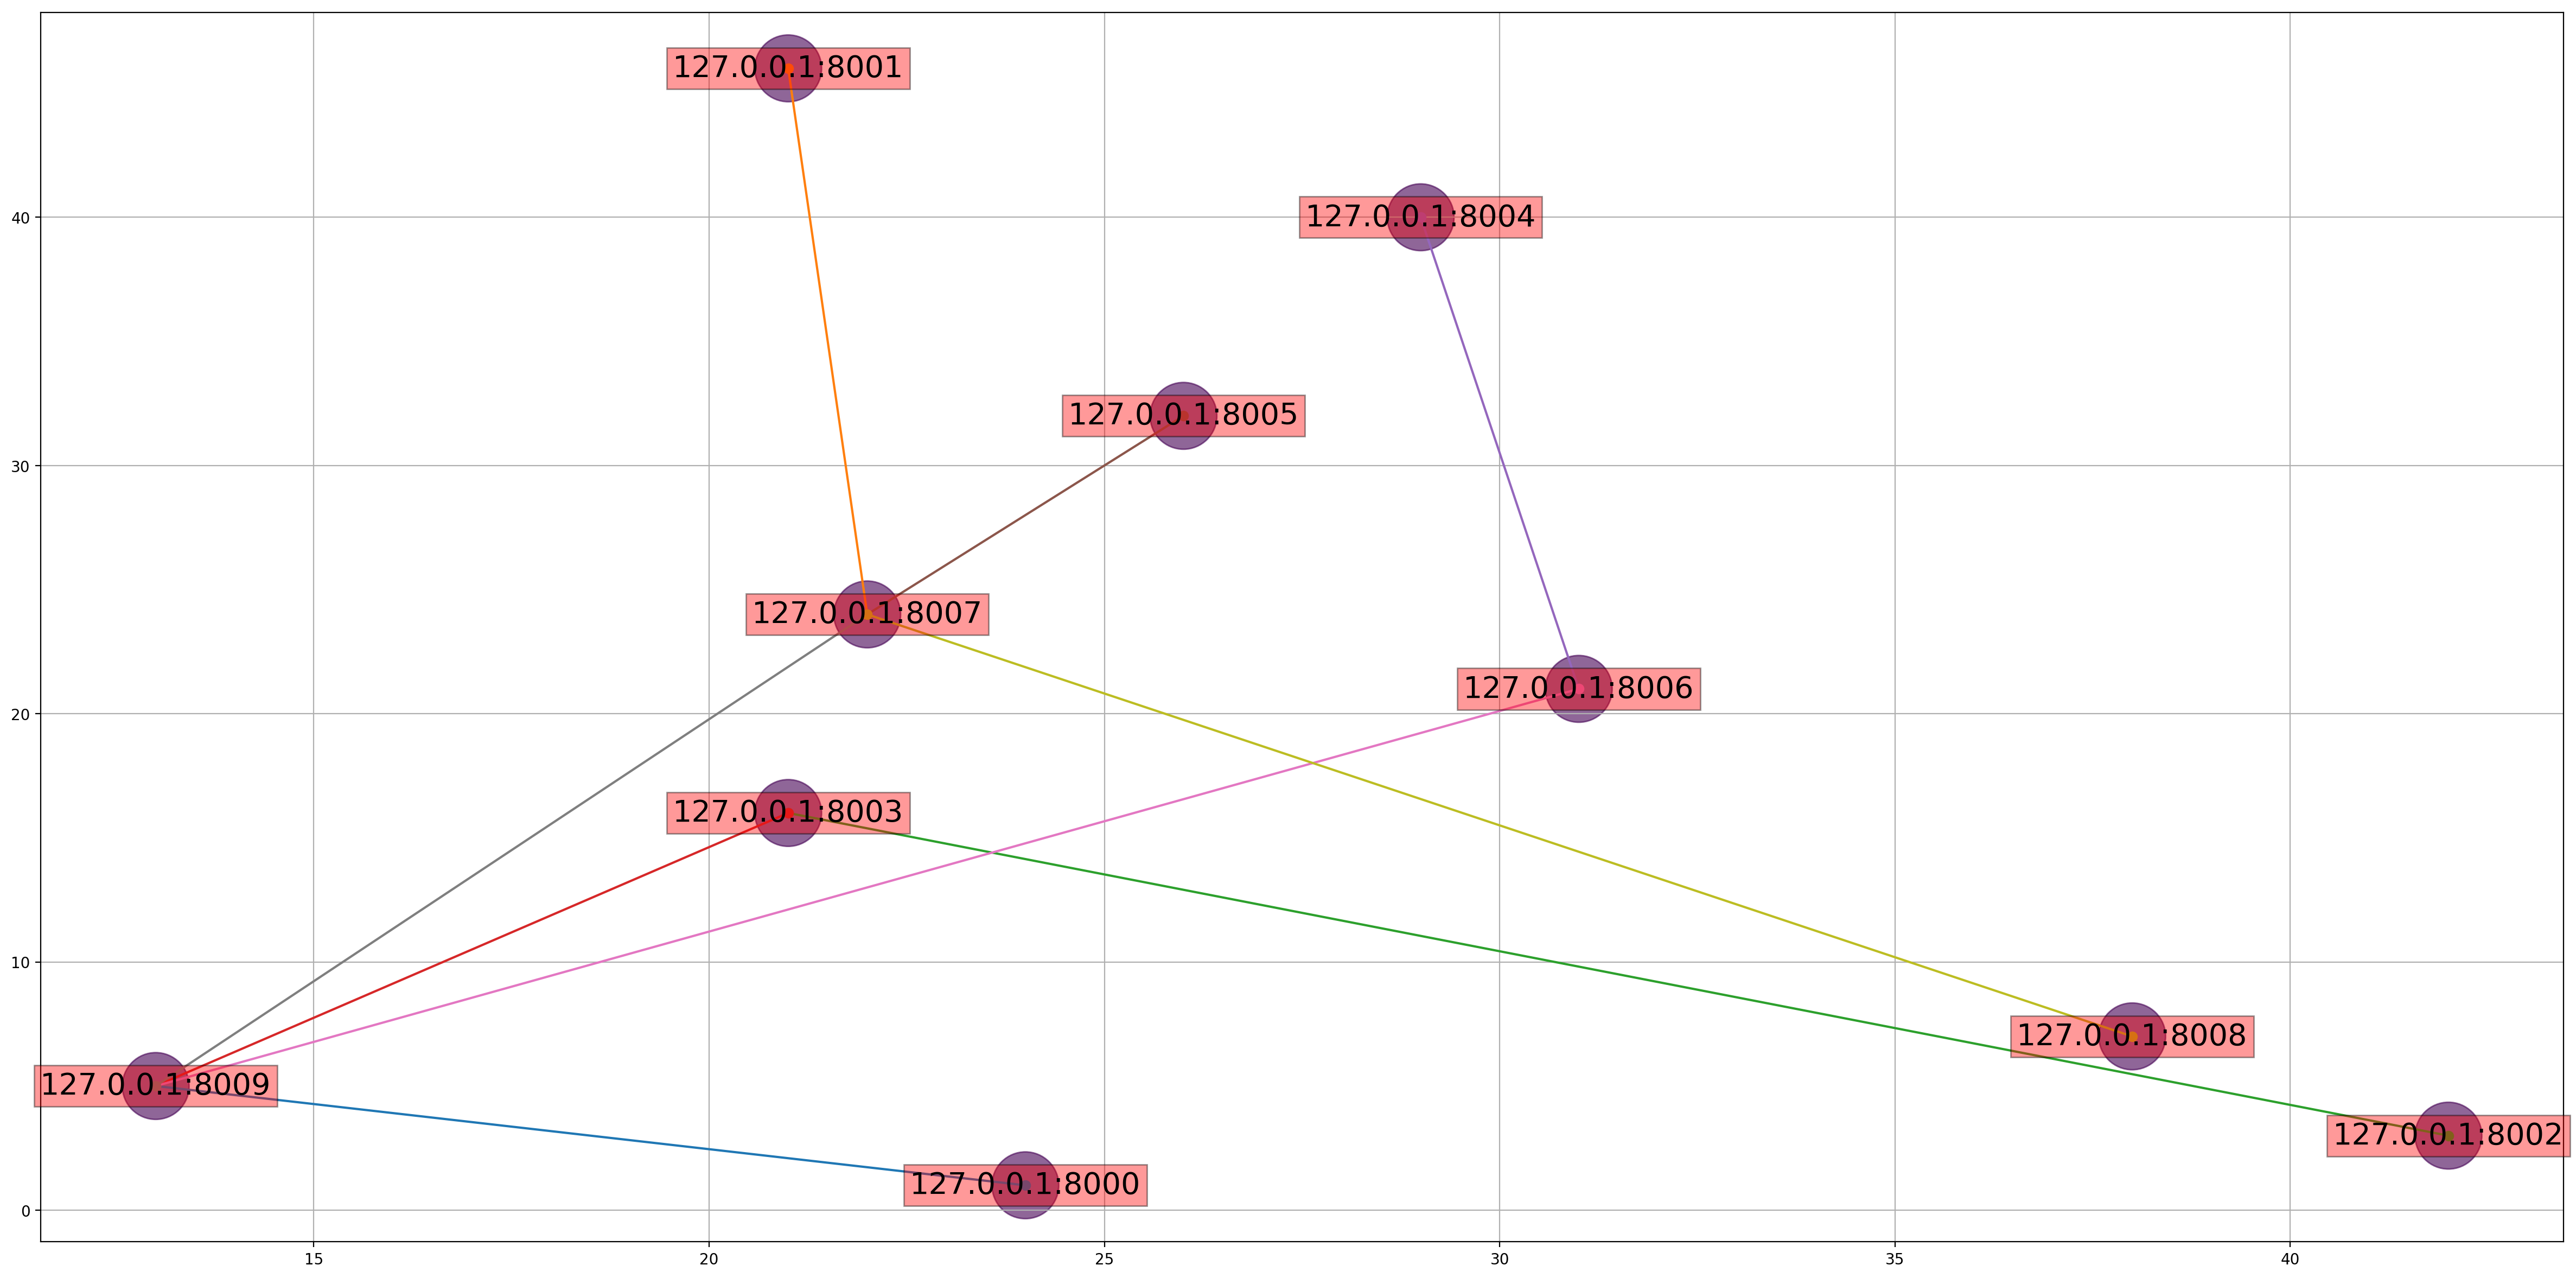

In [32]:
network.plot_network()
network.plt_dest_connection('127.0.0.1:8009')

Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New 

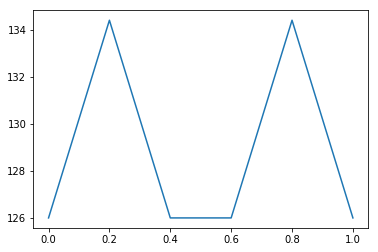

In [33]:
network.plot_transfer_stat('127.0.0.1:8009')

In [34]:
network.nodes['127.0.0.1:8009'].msg_box

{'127.0.0.1:8000': 'PING',
 '127.0.0.1:8001': 'PING',
 '127.0.0.1:8002': 'PING',
 '127.0.0.1:8003': 'PING',
 '127.0.0.1:8004': 'PING',
 '127.0.0.1:8005': 'PING',
 '127.0.0.1:8006': 'PING',
 '127.0.0.1:8007': 'PING',
 '127.0.0.1:8008': 'PING'}

Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent

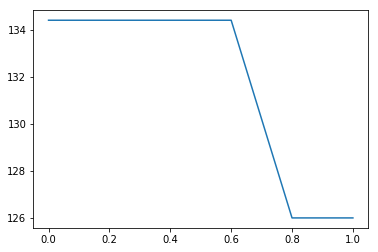

In [35]:
network.plot_transfer_stat('127.0.0.1:8009')